## Introduction

The task is to predict which category an article belongs to (there 5 categorories) given its title and the titles of its references / titles of articles referring to the article (a network of references).

Here I use text mining techniques - stopword removals, tf-df matrices, bag-of-words (BoW) in combination with multinomial logistic regression, naive bayes, and multi-layer perceptron. 

Using tf-idf matrix of own titles+reference titles allows getting 82% accuracy with logistic regression and 82.6% accuracy with MLP (both numbers are accuracy obtained when predictions were uploaded to Kaggle).

## Libraries installation and data prep


In [ ]:
!pip install NLTK

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import collections
from nltk import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD          
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from nltk.stem.snowball import SnowballStemmer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# download the repo to get access to data
!rm -rf DL-Kaggle-competition/
!git clone https://github.com/millasni/DL-Kaggle-competition/

Cloning into 'DL-Kaggle-competition'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 3), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
train = pd.read_csv('DL-Kaggle-competition/train.csv') 
test = pd.read_csv('DL-Kaggle-competition/test.csv') 
text = pd.read_csv('DL-Kaggle-competition/text.csv') 
reference = pd.read_csv('DL-Kaggle-competition/reference.csv') 
reference_classes = pd.read_csv('DL-Kaggle-competition/ref_class_shares.csv') 
cross_ref = pd.read_csv('DL-Kaggle-competition/ref_in_out.csv') 

In [ ]:
train = train.join(text, how='left', on='id',  lsuffix='', rsuffix='text')
train.head()

,id,label,idtext,title
0,0,1,0,interactive visual exploration of neighbor bas...
1,3,1,3,relational division four algorithms and their ...
2,6,1,6,simplifying xml schema effortless handling of ...
3,8,0,8,funbase a function based information managemen...
4,9,0,9,inverted matrix efficient discovery of frequen...


In [ ]:
test = test.join(text, how='left', on='id',  lsuffix='', rsuffix='text')
test.head()

,id,idtext,title
0,1,1,autodomainmine a graphical data mining system ...
1,2,2,anipqo almost non intrusive parametric query o...
2,4,4,selection and ranking of text from highly impe...
3,5,5,conditional random fields for multi agent rein...
4,7,7,multi dimensional description logics


In [ ]:
# One hot encode our labels
Y_dum = pd.get_dummies(train["label"])
Y_dum
Y = train.label
Y

0        1
1        1
2        1
3        0
4        0
        ..
12774    4
12775    3
12776    2
12777    2
12778    1
Name: label, Length: 12779, dtype: int64

In [ ]:
X = list(train['title'])
print(X)
Y = np.array(list(train['label']))
print(Y)

['interactive visual exploration of neighbor based patterns in data streams', 'relational division four algorithms and their performance', 'simplifying xml schema effortless handling of nondeterministic regular expressions', 'funbase a function based information management system', 'inverted matrix efficient discovery of frequent items in large datasets in the context of interactive mining', 'computational aspects of covering in dominance graphs', 'feaspar   a feature structure parser learning to parse spoken language', 'assessing the scenic route measuring the value of search trails in web logs', 'webanywhere enabling a screen reading interface for the web on any computer', 'non standard semantics for the method of temporal arguments', 'exsearch a novel vertical search engine for online barter business', 'query evaluation and progression in aol knowledge bases', 'cryptanalytic attacks on pseudorandom number generators', 'threshold concepts in computer science do they exist and are the

In [ ]:
# Filter stopwords 
from nltk.corpus import stopwords
nltk_stop = stopwords.words('english')
print(nltk_stop)
print(len(nltk_stop))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
nltk_stop = nltk_stop + ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']

##USING ONLY ARTICLE TITLES (NO REFERENCE TITLES)

## Only tokenization

In [ ]:
# Tokenize only
def tokenize(text): 
    return [w.lower() for w in word_tokenize(str(text))]

In [ ]:
Count_vec = CountVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)                #Bag Of Words
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)         #TF IDF

In [ ]:
# transform text into BoW and TFIDF matrices
BoW_matrix = Count_vec.fit_transform(X)   
tfidf_matrix = tfidf_vectorizer.fit_transform(X)  

In [ ]:
print(BoW_matrix.shape)
print(tfidf_matrix.shape)

(12779, 4483)
(12779, 4483)


### Predicting

In [ ]:
X_BoW_train, X_BoW_test, Y_BoW_train, Y_BoW_test = train_test_split(BoW_matrix, Y, test_size=0.2, random_state = 1234)
X_TFIDF_train, X_TFIDF_test, Y_TFIDF_train, Y_TFIDF_test = train_test_split(tfidf_matrix, Y, test_size=0.2, random_state = 1234)

#### Multinomial Logistic Regression

In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial', C=i)
  clf_log.fit(X_BoW_train, Y_BoW_train)
  y_pred_log = clf_log.predict(X_BoW_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.316510172143975
Penaly:  0.0001 Model Accuracy:  0.3673708920187793
Penaly:  0.001 Model Accuracy:  0.5109546165884195
Penaly:  0.01 Model Accuracy:  0.6181533646322379
Penaly:  0.1 Model Accuracy:  0.7038341158059468
Penaly:  1 Model Accuracy:  0.7053990610328639
Penaly:  2 Model Accuracy:  0.6995305164319249
Penaly:  5 Model Accuracy:  0.6838810641627543
Penaly:  10 Model Accuracy:  0.6705790297339593


In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=i)
  clf_log.fit(X_TFIDF_train, Y_TFIDF_train)
  y_pred_log = clf_log.predict(X_TFIDF_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_TFIDF_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.22652582159624413
Penaly:  0.0001 Model Accuracy:  0.32355242566510173
Penaly:  0.001 Model Accuracy:  0.3669796557120501
Penaly:  0.01 Model Accuracy:  0.5469483568075117
Penaly:  0.1 Model Accuracy:  0.6631455399061033
Penaly:  1 Model Accuracy:  0.7245696400625978
Penaly:  2 Model Accuracy:  0.7198748043818466
Penaly:  5 Model Accuracy:  0.7097026604068858
Penaly:  10 Model Accuracy:  0.6979655712050078


In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=1)
  clf_log.fit(tfidf_matrix[train_], Y[train_])
  y_pred_log = clf_log.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_log))
  cvscores.append(accuracy_score(Y[test_], y_pred_log))

Model Accuracy:  0.729264475743349
Model Accuracy:  0.7214397496087637
Model Accuracy:  0.7480438184663537
Model Accuracy:  0.7112676056338029
Model Accuracy:  0.7143974960876369
Model Accuracy:  0.7394366197183099
Model Accuracy:  0.7206572769953051
Model Accuracy:  0.7230046948356808
Model Accuracy:  0.7214397496087637
Model Accuracy:  0.7439310884886453


0.727% (+/- 0.012%)


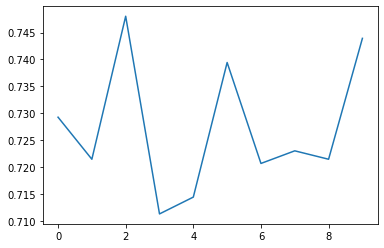

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

##### --> Making predictions for Kaggle

In [ ]:
X_new = tfidf_vectorizer.transform(test.title)

In [ ]:
Y_new5 = clf_log.predict(X_new)

In [ ]:
test5 = pd.DataFrame(list(zip(test['id'], Y_new5)), 
               columns = ['id', 'label'])
test5
test5.to_csv('test5.csv',index=False)

#### Naive Bayes

In [ ]:
mNB = MultinomialNB()
mNB.fit(X_BoW_train, Y_BoW_train)
y_pred_mNB = mNB.predict(X_BoW_test)
print('Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_mNB))
confusion_matrix(Y_BoW_test, y_pred_mNB)

Model Accuracy:  0.72339593114241


array([[381, 117,  52,  14,  31],
       [ 80, 455,  21,  18,   5],
       [ 66,  27, 399,  32,  37],
       [ 18,  50,  38, 386,   9],
       [ 36,   6,  41,   9, 228]])

In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  mNB = MultinomialNB()
  mNB.fit(tfidf_matrix[train_], Y[train_])
  y_pred_mNB = mNB.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_mNB))
  cvscores.append(accuracy_score(Y[test_], y_pred_mNB))

Model Accuracy:  0.7151799687010955
Model Accuracy:  0.7183098591549296
Model Accuracy:  0.7339593114241002
Model Accuracy:  0.7128325508607198
Model Accuracy:  0.690923317683881
Model Accuracy:  0.7417840375586855
Model Accuracy:  0.7128325508607198
Model Accuracy:  0.7198748043818466
Model Accuracy:  0.7065727699530516
Model Accuracy:  0.7541111981205951


0.721% (+/- 0.017%)


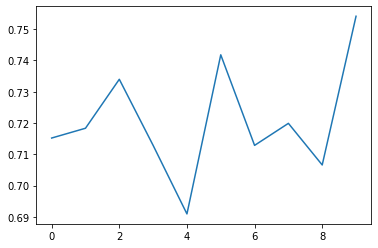

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

## Tokenization and stemming

In [ ]:
# Tokenize and stem...
from nltk.stem import PorterStemmer
snow = SnowballStemmer("english",ignore_stopwords=True)
def tokenize(text): 
    return [snow.stem(w.lower()) for w in word_tokenize(str(text))]

In [ ]:
Count_vec = CountVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)                #Bag Of Words
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)         #TF IDF

In [ ]:
# transform text into BoW and TFIDF matrices
BoW_matrix = Count_vec.fit_transform(X)   #modélisation par Bag of Words
tfidf_matrix = tfidf_vectorizer.fit_transform(X)   #modélisation en TF-IDF

In [ ]:
print(BoW_matrix.shape)
print(tfidf_matrix.shape)

# print(BoW_matrix)
# print(tfidf_matrix)

(12779, 3064)
(12779, 3064)




### Predicting

In [ ]:
X_BoW_train, X_BoW_test, Y_BoW_train, Y_BoW_test = train_test_split(BoW_matrix, Y, test_size=0.2, random_state = 1234)
X_TFIDF_train, X_TFIDF_test, Y_TFIDF_train, Y_TFIDF_test = train_test_split(tfidf_matrix, Y, test_size=0.2, random_state = 1234)

#### Multinomial Logistic Regression

In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial', C=i)
  clf_log.fit(X_BoW_train, Y_BoW_train)
  y_pred_log = clf_log.predict(X_BoW_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.3368544600938967
Penaly:  0.0001 Model Accuracy:  0.3732394366197183
Penaly:  0.001 Model Accuracy:  0.5324726134585289
Penaly:  0.01 Model Accuracy:  0.6349765258215962
Penaly:  0.1 Model Accuracy:  0.7085289514866979
Penaly:  1 Model Accuracy:  0.7057902973395931
Penaly:  2 Model Accuracy:  0.7018779342723005
Penaly:  5 Model Accuracy:  0.6913145539906104
Penaly:  10 Model Accuracy:  0.6811424100156495


In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=i)
  clf_log.fit(X_TFIDF_train, Y_TFIDF_train)
  y_pred_log = clf_log.predict(X_TFIDF_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_TFIDF_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.2269170579029734
Penaly:  0.0001 Model Accuracy:  0.34820031298904536
Penaly:  0.001 Model Accuracy:  0.3798904538341158
Penaly:  0.01 Model Accuracy:  0.5755086071987481
Penaly:  0.1 Model Accuracy:  0.676056338028169
Penaly:  1 Model Accuracy:  0.7245696400625978
Penaly:  2 Model Accuracy:  0.7194835680751174
Penaly:  5 Model Accuracy:  0.706964006259781
Penaly:  10 Model Accuracy:  0.6971830985915493


#### Naive Bayes

In [ ]:
mNB = MultinomialNB()
mNB.fit(X_BoW_train, Y_BoW_train)
y_pred_mNB = mNB.predict(X_BoW_test)
print('Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_mNB))
confusion_matrix(Y_BoW_test, y_pred_mNB)

Model Accuracy:  0.7226134585289515


array([[382, 120,  56,  10,  27],
       [ 83, 443,  27,  23,   3],
       [ 63,  24, 404,  35,  35],
       [ 15,  52,  38, 386,  10],
       [ 29,   9,  40,  10, 232]])

## Summary of accuracy 

Accuracy when using only titles of articles themselves

| Model          | Matrix used | Stemming | Valid.accuracy |
|----------------|-------------|----------|----------------|
| Logistic       | BoW         | 0        | 0.7054         |
| Logistic       | BoW         | 1        | 0.7058         |
| Logistic       | TFIDF       | 0        | 0.7246         |
| Logistic       | TFIDF       | 1        | 0.7246         |
| Multinomial NB | BoW         | 0        | 0.7234         |
| Multinomial NB | BoW         | 1        | 0.7226         |



## USING ARTICLE TITLES + REFERENCE TITLES

#### Data prep using one new data file including references

The file contains **ref_to** - articles an article is citing and **ref_from** - articles citing this article 

In [ ]:
cross_ref.head()

,Unnamed: 0,id,label,ref_to,ref_from
0,1,0,1.0,a framework for clustering evolving data strea...,NaN
1,2,3,1.0,implementation techniques for main memory data...,providing better support for a class of decisi...
2,3,6,1.0,statix making xml count answering xml queries ...,NaN
3,4,8,0.0,temporal databases status and research direc...,NaN
4,5,9,0.0,dynamic itemset counting and implication rules...,pattern lattice traversal by selective jumps


In [ ]:
cross_ref2 = cross_ref.fillna("0")

In [ ]:
train3 = train.join(cross_ref2.set_index('id'), how = 'left', on="id", rsuffix="cross")


In [ ]:
train3["merged"] = train3["title"] +" "+ train3["ref_to"] +" "+ train3["ref_from"]

In [ ]:
train3[:3]

,id,label,idtext,title,Unnamed: 0,labelcross,ref_to,ref_from,merged
0,0,1,0,interactive visual exploration of neighbor bas...,1,1,a framework for clustering evolving data strea...,0,interactive visual exploration of neighbor bas...
1,3,1,3,relational division four algorithms and their ...,2,1,implementation techniques for main memory data...,providing better support for a class of decisi...,relational division four algorithms and their ...
2,6,1,6,simplifying xml schema effortless handling of ...,3,1,statix making xml count answering xml queries ...,0,simplifying xml schema effortless handling of ...


In [ ]:
test3 = test.join(cross_ref2.set_index('id'), how = 'left', on="id", rsuffix="cross")

In [ ]:
test3["merged"] = test3["title"] +" "+ test3["ref_to"] +" "+ test3["ref_from"]

In [ ]:
test3[:3]

,id,idtext,title,Unnamed: 0,label,ref_to,ref_from,merged
0,1,1,autodomainmine a graphical data mining system ...,12780,0,what is the nearest neighbor in high dimension...,0,autodomainmine a graphical data mining system ...
1,2,2,anipqo almost non intrusive parametric query o...,12781,0,parametric query optimization optimization of ...,on the production of anorexic plan diagrams,anipqo almost non intrusive parametric query o...
2,4,4,selection and ranking of text from highly impe...,12782,0,0,0,selection and ranking of text from highly impe...


In [ ]:
X2 = list(train3["merged"])
print(X2[:3])

['interactive visual exploration of neighbor based patterns in data streams a framework for clustering evolving data streams mining adaptively frequent closed unlabeled rooted trees in data streams 0', 'relational division four algorithms and their performance implementation techniques for main memory database systems gamma   a high performance dataflow database machine hashing methods and relational algebra operations multiprocessor hash based join algorithms providing better support for a class of decision support queries dynamic query evaluation plans encapsulation of parallelism in the volcano query processing system', 'simplifying xml schema effortless handling of nondeterministic regular expressions statix making xml count answering xml queries on heterogeneous data sources schema based scheduling of event processors and buffer minimization for queries on structured data streams linear time membership in a class of regular expressions with interleaving and counting shrex managing

## Only tokenization

In [ ]:
# Tokenize only
def tokenize(text): 
    return [w.lower() for w in word_tokenize(str(text))]

In [ ]:
Count_vec = CountVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)                #Bag Of Words
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)         #TF IDF

In [ ]:
# transform text into BoW and TFIDF matrices
BoW_matrix = Count_vec.fit_transform(X2)   
tfidf_matrix = tfidf_vectorizer.fit_transform(X2)  

In [ ]:
print(BoW_matrix.shape)
print(tfidf_matrix.shape)

# print(BoW_matrix)
# print(tfidf_matrix)

(12779, 9211)
(12779, 9211)


In [ ]:
tfidf_matrix

<12779x9211 sparse matrix of type '<class 'numpy.float64'>'
	with 389322 stored elements in Compressed Sparse Row format>

### Predicting

In [ ]:
X_BoW_train, X_BoW_test, Y_BoW_train, Y_BoW_test = train_test_split(BoW_matrix, Y, test_size=0.2, random_state = 245)
X_TFIDF_train, X_TFIDF_test, Y_TFIDF_train, Y_TFIDF_test = train_test_split(tfidf_matrix, Y, test_size=0.2, random_state = 245)

#### Multinomial Logistic Regression

In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial', C=i)
  clf_log.fit(X_BoW_train, Y_BoW_train)
  y_pred_log = clf_log.predict(X_BoW_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.4964788732394366
Penaly:  0.0001 Model Accuracy:  0.607981220657277
Penaly:  0.001 Model Accuracy:  0.702660406885759
Penaly:  0.01 Model Accuracy:  0.7523474178403756
Penaly:  0.1 Model Accuracy:  0.7769953051643192
Penaly:  1 Model Accuracy:  0.7809076682316118
Penaly:  2 Model Accuracy:  0.775039123630673
Penaly:  5 Model Accuracy:  0.7668231611893583
Penaly:  10 Model Accuracy:  0.7601721439749609


In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=i)
  clf_log.fit(X_TFIDF_train, Y_TFIDF_train)
  y_pred_log = clf_log.predict(X_TFIDF_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_TFIDF_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.23395931142410015
Penaly:  0.0001 Model Accuracy:  0.3888888888888889
Penaly:  0.001 Model Accuracy:  0.5356025039123631
Penaly:  0.01 Model Accuracy:  0.6948356807511737
Penaly:  0.1 Model Accuracy:  0.7785602503912363
Penaly:  1 Model Accuracy:  0.8133802816901409
Penaly:  2 Model Accuracy:  0.8133802816901409
Penaly:  5 Model Accuracy:  0.8118153364632238
Penaly:  10 Model Accuracy:  0.8067292644757433


In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=1)
  clf_log.fit(tfidf_matrix[train_], Y[train_])
  y_pred_log = clf_log.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_log))
  cvscores.append(accuracy_score(Y[test_], y_pred_log))

Model Accuracy:  0.8215962441314554
Model Accuracy:  0.8028169014084507
Model Accuracy:  0.8317683881064163
Model Accuracy:  0.8348982785602503
Model Accuracy:  0.8082942097026604
Model Accuracy:  0.827073552425665
Model Accuracy:  0.8286384976525821
Model Accuracy:  0.8200312989045383
Model Accuracy:  0.8075117370892019
Model Accuracy:  0.8332028191072827


0.822% (+/- 0.011%)


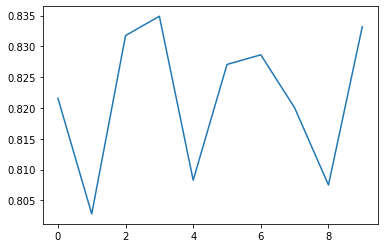

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

##### --> Making predictions for Kaggle

In [ ]:
# fit model on the whole data
clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=1)
clf_log.fit(tfidf_matrix, Y)
# clf_log.fit(X_TFIDF_train, Y_TFIDF_train)
y_pred_log = clf_log.predict(X_TFIDF_test)
print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_TFIDF_test, y_pred_log))

Penaly:  10 Model Accuracy:  0.8775430359937402


In [ ]:
X_new = tfidf_vectorizer.transform(test3.merged)

In [ ]:
Y_new12 = clf_log.predict(X_new)

In [ ]:
test12 = pd.DataFrame(list(zip(test['id'], Y_new12)), 
               columns = ['id', 'label'])
test12
test12.to_csv('test12.csv',index=False)

#### Naive Bayes

In [ ]:
mNB = MultinomialNB()
mNB.fit(X_BoW_train, Y_BoW_train)
y_pred_mNB = mNB.predict(X_BoW_test)
print('Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_mNB))
confusion_matrix(Y_BoW_test, y_pred_mNB)

Model Accuracy:  0.8075117370892019


array([[402, 113,  76,   9,  16],
       [ 44, 511,  23,  19,   1],
       [ 40,   9, 468,  22,  29],
       [  2,   7,  28, 447,   4],
       [ 19,   0,  29,   2, 236]])

In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  mNB = MultinomialNB()
  mNB.fit(tfidf_matrix[train_], Y[train_])
  y_pred_mNB = mNB.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_mNB))
  cvscores.append(accuracy_score(Y[test_], y_pred_mNB))

Model Accuracy:  0.8114241001564946
Model Accuracy:  0.798904538341158
Model Accuracy:  0.8223787167449139
Model Accuracy:  0.8223787167449139
Model Accuracy:  0.7949921752738655
Model Accuracy:  0.8255086071987481
Model Accuracy:  0.8153364632237872
Model Accuracy:  0.8114241001564946
Model Accuracy:  0.8153364632237872
Model Accuracy:  0.8285043069694596


0.815% (+/- 0.010%)


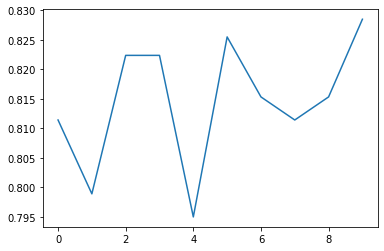

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

#### MLP on TF-IDF matrix

In [ ]:
from sklearn import metrics
from sklearn import neural_network
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler 

In [ ]:
# decreade init lr for adam (default optimizer)
hidden_layers = [[20,40],[50,100],[128,256],[50,100,200]]     
alpha_fit = [0.0001, 0.001, 0.01, 0.1, 1]
# output_list = []
for i in range(len(hidden_layers)):
  for j in range(len(alpha_fit)):
    nn = neural_network.MLPClassifier(alpha=alpha_fit[j], # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers)[i],
                                      early_stopping=True, # stop if validation performance decreases
                                      # verbose=True,
                                      random_state=1234,
                                      max_iter=1000, learning_rate_init=0.0001) # DECREASED LR

    nn.fit(X_TFIDF_train, Y_TFIDF_train)  
    nnscore = nn.predict(X_TFIDF_test)
    acc = metrics.accuracy_score(Y_TFIDF_test, nnscore)
    print("Val.accuracy: %.3f " % acc,"architecture",hidden_layers[i], "alpha:", alpha_fit[j],"number of parameters:")

Val.accuracy: 0.822  architecture [20, 40] alpha: 0.0001 number of parameters:
Val.accuracy: 0.820  architecture [20, 40] alpha: 0.001 number of parameters:
Val.accuracy: 0.820  architecture [20, 40] alpha: 0.01 number of parameters:
Val.accuracy: 0.818  architecture [20, 40] alpha: 0.1 number of parameters:
Val.accuracy: 0.796  architecture [20, 40] alpha: 1 number of parameters:
Val.accuracy: 0.816  architecture [50, 100] alpha: 0.0001 number of parameters:
Val.accuracy: 0.819  architecture [50, 100] alpha: 0.001 number of parameters:
Val.accuracy: 0.820  architecture [50, 100] alpha: 0.01 number of parameters:
Val.accuracy: 0.818  architecture [50, 100] alpha: 0.1 number of parameters:
Val.accuracy: 0.809  architecture [50, 100] alpha: 1 number of parameters:
Val.accuracy: 0.827  architecture [128, 256] alpha: 0.0001 number of parameters:
Val.accuracy: 0.828  architecture [128, 256] alpha: 0.001 number of parameters:
Val.accuracy: 0.829  architecture [128, 256] alpha: 0.01 number of

In [ ]:
# decreade init lr for adam (default optimizer)
hidden_layers = [[256,512]]     
alpha_fit = [0.0001, 0.001, 0.01, 0.1]
# output_list = []
for i in range(len(hidden_layers)):
  for j in range(len(alpha_fit)):
    nn = neural_network.MLPClassifier(alpha=alpha_fit[j], # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers)[i],
                                      early_stopping=True, # stop if validation performance decreases
                                      # verbose=True,
                                      random_state=1234,
                                      max_iter=1000, learning_rate_init=0.0001) # DECREASED LR

    nn.fit(X_TFIDF_train, Y_TFIDF_train)  
    nnscore = nn.predict(X_TFIDF_test)
    acc = metrics.accuracy_score(Y_TFIDF_test, nnscore)
    print("Val.accuracy: %.3f " % acc,"architecture",hidden_layers[i], "alpha:", alpha_fit[j],"number of parameters:")

Val.accuracy: 0.823  architecture [256, 512] alpha: 0.0001 number of parameters:
Val.accuracy: 0.822  architecture [256, 512] alpha: 0.001 number of parameters:
Val.accuracy: 0.822  architecture [256, 512] alpha: 0.01 number of parameters:
Val.accuracy: 0.822  architecture [256, 512] alpha: 0.1 number of parameters:


Training the best model for predictions

In [ ]:
nn = neural_network.MLPClassifier(alpha=0.1, # l2-regularization (weight decay)
                                  hidden_layer_sizes=(128,256),
                                  early_stopping=True, # stop if validation performance decreases
                                  verbose=True,
                                  random_state=1234,
                                  # activation="logistic",
                                  # learning_rate="invscaling",
                                  max_iter=1000, learning_rate_init=0.0001) # DECREASED LR)

nn.fit(X_TFIDF_train, Y_TFIDF_train)  
nnscore = nn.predict(X_TFIDF_test)
acc = metrics.accuracy_score(Y_TFIDF_test, nnscore)
print("Valid.acc: %.3f " % acc,"architecture",hidden_layers[i], "alpha:", alpha_fit[j])

Iteration 1, loss = 1.69648694
Validation score: 0.399804
Iteration 2, loss = 1.64069183
Validation score: 0.490714
Iteration 3, loss = 1.55326802
Validation score: 0.676442
Iteration 4, loss = 1.42046965
Validation score: 0.703812
Iteration 5, loss = 1.25521595
Validation score: 0.739003
Iteration 6, loss = 1.08507426
Validation score: 0.772239
Iteration 7, loss = 0.92971896
Validation score: 0.801564
Iteration 8, loss = 0.80157497
Validation score: 0.804497
Iteration 9, loss = 0.70252763
Validation score: 0.816227
Iteration 10, loss = 0.62851394
Validation score: 0.820137
Iteration 11, loss = 0.57446080
Validation score: 0.821114
Iteration 12, loss = 0.53365285
Validation score: 0.820137
Iteration 13, loss = 0.50234485
Validation score: 0.823069
Iteration 14, loss = 0.47714002
Validation score: 0.821114
Iteration 15, loss = 0.45613747
Validation score: 0.823069
Iteration 16, loss = 0.43805748
Validation score: 0.826979
Iteration 17, loss = 0.42204464
Validation score: 0.825024
Iterat

In [ ]:
acc = metrics.accuracy_score(Y_TFIDF_test, nnscore)
print("Accuracy: %.3f " % acc)

Accuracy: 0.831 


##### --> Making predictions for Kaggle (the best)

In [ ]:
X_new = tfidf_vectorizer.transform(test3.merged)

In [ ]:
Y_new15 = nn.predict(X_new)

In [ ]:
test15 = pd.DataFrame(list(zip(test['id'], Y_new15)), 
               columns = ['id', 'label'])
test15
test15.to_csv('test15.csv',index=False)

In [ ]:
nn = neural_network.MLPClassifier(alpha=0.1, # l2-regularization (weight decay)
                                  hidden_layer_sizes=(128,256),
                                  # early_stopping=True, # stop if validation performance decreases
                                  verbose=True,
                                  random_state=1234,
                                  # activation="logistic",
                                  # learning_rate="invscaling",
                                  max_iter=15, learning_rate_init=0.0001) # DECREASED LR)

nn.fit(X_TFIDF_train, Y_TFIDF_train)  
nnscore = nn.predict(X_TFIDF_test)
acc = metrics.accuracy_score(Y_TFIDF_test, nnscore)
print("Valid.acc: %.3f " % acc)

Iteration 1, loss = 1.69443963
Iteration 2, loss = 1.62881783
Iteration 3, loss = 1.52311622
Iteration 4, loss = 1.36491842
Iteration 5, loss = 1.17893639
Iteration 6, loss = 0.99927332
Iteration 7, loss = 0.84849890
Iteration 8, loss = 0.73221813
Iteration 9, loss = 0.64715379
Iteration 10, loss = 0.58686741
Iteration 11, loss = 0.54345389
Iteration 12, loss = 0.51059483
Iteration 13, loss = 0.48473147
Iteration 14, loss = 0.46321495
Iteration 15, loss = 0.44486996
Valid.acc: 0.829 


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Tokenization and stemming

In [ ]:
# Tokenize and stem...
from nltk.stem import PorterStemmer
snow = SnowballStemmer("english",ignore_stopwords=True)
def tokenize(text): 
    return [snow.stem(w.lower()) for w in word_tokenize(str(text))]

In [ ]:
Count_vec = CountVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)                #Bag Of Words
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,1), min_df=2, stop_words=nltk_stop)         #TF IDF

In [ ]:
# transform text into BoW and TFIDF matrices
BoW_matrix = Count_vec.fit_transform(X2)   #modélisation par Bag of Words
tfidf_matrix = tfidf_vectorizer.fit_transform(X2)   #modélisation en TF-IDF

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
print(BoW_matrix.shape)
print(tfidf_matrix.shape)

# print(BoW_matrix)
# print(tfidf_matrix)

(12779, 6310)
(12779, 6310)




### Predicting

In [ ]:
X_BoW_train, X_BoW_test, Y_BoW_train, Y_BoW_test = train_test_split(BoW_matrix, Y, test_size=0.2, random_state = 245)
X_TFIDF_train, X_TFIDF_test, Y_TFIDF_train, Y_TFIDF_test = train_test_split(tfidf_matrix, Y, test_size=0.2, random_state = 245)

#### Multinomial Logistic Regression

Poor performance on BoW, better - on TF-IDF. Trying several penalty values for regression on TF-IDF 

In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial', C=i)
  clf_log.fit(X_BoW_train, Y_BoW_train)
  y_pred_log = clf_log.predict(X_BoW_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.5015649452269171
Penaly:  0.0001 Model Accuracy:  0.6197183098591549
Penaly:  0.001 Model Accuracy:  0.7077464788732394
Penaly:  0.01 Model Accuracy:  0.7586071987480438
Penaly:  0.1 Model Accuracy:  0.7812989045383412
Penaly:  1 Model Accuracy:  0.7789514866979655
Penaly:  2 Model Accuracy:  0.7734741784037559
Penaly:  5 Model Accuracy:  0.7609546165884195
Penaly:  10 Model Accuracy:  0.7554773082942097


In [ ]:
penalty = [0.00001,0.0001,0.001,0.01,0.1,1,2,5,10]
for i in penalty:
  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=i)
  clf_log.fit(X_TFIDF_train, Y_TFIDF_train)
  y_pred_log = clf_log.predict(X_TFIDF_test)
  print('Penaly: ',i,'Model Accuracy: ', accuracy_score(Y_TFIDF_test, y_pred_log))

Penaly:  1e-05 Model Accuracy:  0.23395931142410015
Penaly:  0.0001 Model Accuracy:  0.3888888888888889
Penaly:  0.001 Model Accuracy:  0.547339593114241
Penaly:  0.01 Model Accuracy:  0.7097026604068858
Penaly:  0.1 Model Accuracy:  0.7832550860719875
Penaly:  1 Model Accuracy:  0.8059467918622848
Penaly:  2 Model Accuracy:  0.804773082942097
Penaly:  5 Model Accuracy:  0.7985133020344288
Penaly:  10 Model Accuracy:  0.7926447574334898


##### C=1

In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=1)
  clf_log.fit(tfidf_matrix[train_], Y[train_])
  y_pred_log = clf_log.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_log))
  cvscores.append(accuracy_score(Y[test_], y_pred_log))

Model Accuracy:  0.8192488262910798
Model Accuracy:  0.8082942097026604
Model Accuracy:  0.8247261345852895
Model Accuracy:  0.8317683881064163
Model Accuracy:  0.812206572769953
Model Accuracy:  0.838810641627543
Model Accuracy:  0.8294209702660407
Model Accuracy:  0.8098591549295775
Model Accuracy:  0.810641627543036
Model Accuracy:  0.8230227094753328


0.821% (+/- 0.010%)


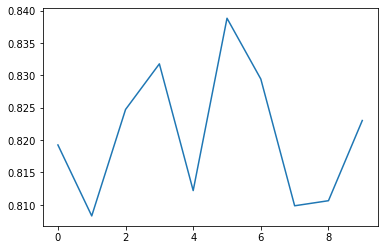

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

##### C=2

In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =2000, multi_class='multinomial',C=2)
  clf_log.fit(tfidf_matrix[train_], Y[train_])
  y_pred_log = clf_log.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_log))
  cvscores.append(accuracy_score(Y[test_], y_pred_log))

Model Accuracy:  0.823943661971831
Model Accuracy:  0.8098591549295775
Model Accuracy:  0.8208137715179968
Model Accuracy:  0.8278560250391236
Model Accuracy:  0.8161189358372457
Model Accuracy:  0.8341158059467919
Model Accuracy:  0.8286384976525821
Model Accuracy:  0.809076682316119
Model Accuracy:  0.8129890453834115
Model Accuracy:  0.826938136256852


0.821% (+/- 0.008%)


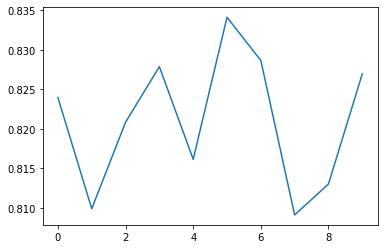

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

#### Naive Bayes

In [ ]:
mNB = MultinomialNB()
mNB.fit(X_BoW_train, Y_BoW_train)
y_pred_mNB = mNB.predict(X_BoW_test)
print('Model Accuracy: ', accuracy_score(Y_BoW_test, y_pred_mNB))
confusion_matrix(Y_BoW_test, y_pred_mNB)

Model Accuracy:  0.8094679186228482


array([[380, 105,  87,   7,  16],
       [ 39, 496,  32,  11,   1],
       [ 36,   3, 475,  23,  24],
       [  6,  10,  32, 450,   3],
       [ 17,   0,  31,   4, 268]])

In [ ]:
# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(tfidf_matrix, Y):

  mNB = MultinomialNB()
  mNB.fit(tfidf_matrix[train_], Y[train_])
  y_pred_mNB = mNB.predict(tfidf_matrix[test_])
  print('Model Accuracy: ', accuracy_score(Y[test_], y_pred_mNB))
  cvscores.append(accuracy_score(Y[test_], y_pred_mNB))

Model Accuracy:  0.7965571205007824
Model Accuracy:  0.8028169014084507
Model Accuracy:  0.8223787167449139
Model Accuracy:  0.810641627543036
Model Accuracy:  0.7887323943661971
Model Accuracy:  0.8192488262910798
Model Accuracy:  0.812206572769953
Model Accuracy:  0.812206572769953
Model Accuracy:  0.810641627543036
Model Accuracy:  0.822239624119029


0.810% (+/- 0.010%)


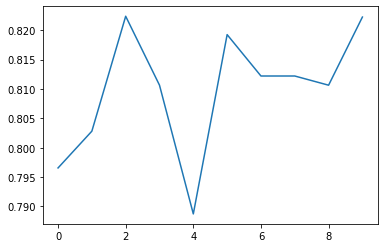

In [ ]:
print("%.3f%% (+/- %.3f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()